# Import library

In [1]:
import time

import statistics 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scikitplot as skplt

#confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


import graphviz
from sklearn.tree import export_graphviz

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Load dataset

In [3]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 3906
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2097 non-null   object 
 1   ratio                  2097 non-null   float64
 2   num_matches_2016-2019  2097 non-null   float64
 3   ratio_2016-2019        2097 non-null   float64
 4   num_matches_2020-2021  2097 non-null   float64
 5   ratio_2020-2021        2097 non-null   float64
 6   hand                   2097 non-null   object 
 7   gender                 2097 non-null   object 
 8   ioc                    2097 non-null   object 
 9   birth                  2097 non-null   float64
 10  ht                     2097 non-null   float64
 11  minutes                2097 non-null   float64
 12  perc_ace               2097 non-null   float64
 13  serv_won_tot_seve      2097 non-null   float64
 14  bpFaced                2097 non-null   float64
 15  perc

### Adding player's rank on tennis player's profile

In [4]:
df_rank = pd.read_csv('../Task1/dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df_rank.info()

C:\Users\Gerlando\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185750 entries, 0 to 185749
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          185750 non-null  object 
 1   tourney_name        185750 non-null  object 
 2   surface             185588 non-null  object 
 3   draw_size           185750 non-null  float64
 4   tourney_level       185750 non-null  object 
 5   tourney_date        185750 non-null  object 
 6   match_num           185750 non-null  float64
 7   winner_id           185750 non-null  float64
 8   winner_name         185750 non-null  object 
 9   winner_hand         185750 non-null  object 
 10  winner_ioc          185750 non-null  object 
 11  loser_id            185750 non-null  float64
 12  loser_name          185750 non-null  object 
 13  loser_hand          185750 non-null  object 
 14  loser_ioc           185750 non-null  object 
 15  score               185581 non-nul

In [5]:
winner_rank = df_rank[['winner_name', 'winner_rank']]
winner_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

loser_rank = df_rank[['loser_name', 'loser_rank']]
loser_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

player_rank = loser_rank.append(winner_rank)
player = df[['name']]
player = pd.merge(player, player_rank, how='left', on='name')
print(player, '\n# of nan:', player['rank'].isna().sum())

                   name    rank
0         AARON ADDISON  1037.0
1         AARON ADDISON  1254.0
2         AARON ADDISON  1255.0
3         AARON ADDISON  1047.0
4         AARON ADDISON  1055.0
...                 ...     ...
266164  ZUZANA ZLOCHOVA   343.0
266165  ZUZANA ZLOCHOVA   335.0
266166  ZUZANA ZLOCHOVA   316.0
266167  ZUZANA ZLOCHOVA   318.0
266168  ZUZANA ZLOCHOVA   316.0

[266169 rows x 2 columns] 
# of nan: 7721


In [6]:
#osserviamo quanti giocatori hanno QUALCHE nan
nan_name = player[player['rank'].isna()]
nan_name['name'].nunique()

770

In [7]:
#prendiamo la media del rank e vediamo se sono rimasti nan (per quelli che avranno nan come rank vuol dire che nel db originale 
# non era presente nessun valore di rank per quel giocatore)
player = player.groupby('name').mean()
player['rank']=player['rank'].round(0)
player['rank'].describe()

count    2062.000000
mean      492.236178
std       329.499585
min         3.000000
25%       242.250000
50%       423.500000
75%       686.750000
max      1908.000000
Name: rank, dtype: float64

In [8]:
#stampo il numero di giocatori che non hanno nemmeno un valore associato al rank
player.isna().sum()

rank    35
dtype: int64

In [9]:
player['rank'].nunique()

940

In [10]:
player.reset_index(inplace = True)
player

,name,rank
0,AARON ADDISON,1131.0
1,ABBIE MYERS,475.0
2,ABHINAV SANJEEV SHANMUGAM,1233.0
3,ABIGAIL TERE APISAH,422.0
4,ABIR EL FAHIMI,NaN
...,...,...
2092,ZIZOU BERGS,369.0
2093,ZOE HIVES,319.0
2094,ZOE KRUGER,750.0
2095,ZSOMBOR PIROS,453.0


In [11]:
#unisco le due tabelle
df = pd.merge(df, player, how='left', on='name')
df.describe()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank
count,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2062.000000
mean,0.485469,102.867907,0.477087,24.060563,0.308706,1993.783500,179.181167,81.005501,6.753925,0.518591,902.097282,7.481683,43.027139,6.755632,6.384015,53.884816,492.236178
std,0.114080,80.423273,0.133781,27.037076,0.264359,5.087836,8.142602,16.358880,5.476795,0.145589,754.170294,3.484798,12.209689,4.643672,1.978579,19.529147,329.499585
min,0.133333,0.000000,0.000000,0.000000,0.000000,1977.000000,155.000000,49.409091,0.000000,0.037581,0.000000,0.000000,0.000000,0.070000,0.000000,0.910000,3.000000
25%,0.421875,28.000000,0.413793,0.000000,0.000000,1990.000000,173.000000,62.852773,2.400000,0.495810,233.000000,5.210000,40.690000,2.550000,5.420000,37.820000,242.250000
50%,0.500000,82.000000,0.500000,12.000000,0.375000,1994.000000,178.000000,82.777778,5.740000,0.575210,661.000000,6.970000,47.180000,6.150000,6.610000,64.330000,423.500000
75%,0.562500,174.000000,0.564103,46.000000,0.533333,1998.000000,185.705882,94.812500,9.840000,0.611270,1505.000000,9.180000,50.000000,10.390000,7.590000,69.650000,686.750000
max,0.834395,316.000000,1.000000,108.000000,1.000000,2006.000000,211.000000,132.724084,40.000000,0.777251,3868.000000,29.930000,94.180000,23.170000,17.890000,80.790000,1908.000000


## Transform categorical features into numerical ones

In [12]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [13]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [14]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2097 non-null   float64
 1   num_matches_2016-2019  2097 non-null   float64
 2   ratio_2016-2019        2097 non-null   float64
 3   num_matches_2020-2021  2097 non-null   float64
 4   ratio_2020-2021        2097 non-null   float64
 5   birth                  2097 non-null   float64
 6   ht                     2097 non-null   float64
 7   minutes                2097 non-null   float64
 8   perc_ace               2097 non-null   float64
 9   serv_won_tot_seve      2097 non-null   float64
 10  bpFaced                2097 non-null   float64
 11  perc_df                2097 non-null   float64
 12  perc_2ndwon            2097 non-null   float64
 13  perc_v_ace             2097 non-null   float64
 14  perc_v_df              2097 non-null   float64
 15  perc

### Write to csv before classification

In [16]:
df.to_csv('dataset/players_classification.csv')

## Labels

Abbiamo bisogno di capire qual'è il target associato ad ogni insieme per fare il processo di classificazione, un idea potrebbe essere utilizzando un attributo specifico che tiene tratta delle "performance" di ogni giocatore, in modo da poter contraddistingure i giocatori più forti da quelli più deboli. Nel nostro caso ci siamo basati sul rank. 

Nota: questa non è una metrica efficace perchè il vero label del giocatore viene calcolato in base a diversi parametri come ad esempio il punteggio realizzato derivante dalla vincita dei vari tornei ma dato che esso risulta difficile stimarlo utilizzare le informazioni sui rank potrebbe essere la soluzione più efficente 

Quindi possiamo usare i percentili o i quartili per contraddistinguere i due tipi di giocatori, in paticolare consideriamo i giocatori più forti quelli che compaiono nei primi 25% del dataset in ordine di rank decrescente, mentre i rimanenti risultano di basso livello

In [17]:
df.sort_values(by=['rank'])

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank,hand_num,gender_num,ioc_num
1805,0.740614,247.0,0.736842,46.0,0.760870,1991.0,168.000000,89.320671,4.20,0.587154,2016.0,5.47,47.88,4.45,7.11,58.31,3.0,1,0,71
1639,0.834395,251.0,0.840637,63.0,0.809524,1986.0,185.000000,128.560922,7.25,0.676923,1571.0,3.77,57.67,12.01,5.74,64.40,3.0,0,1,26
1695,0.829694,209.0,0.842105,20.0,0.700000,1981.0,185.000000,114.490553,17.45,0.710146,918.0,3.40,58.37,10.95,5.59,67.99,4.0,1,1,80
1037,0.698276,280.0,0.710714,68.0,0.647059,1992.0,184.000000,96.256908,15.73,0.614620,2310.0,7.82,45.45,7.39,8.47,63.61,7.0,1,0,20
506,0.693182,300.0,0.700000,52.0,0.653846,1993.0,185.000000,112.975258,12.23,0.662438,2041.0,5.81,53.33,9.89,5.06,69.16,8.0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,0.133333,15.0,0.133333,0.0,0.000000,1999.0,172.137868,97.307692,3.15,0.391993,159.0,9.15,36.12,2.83,5.98,54.02,NaN,2,0,49
1724,0.379310,8.0,0.375000,21.0,0.380952,2002.0,177.500000,61.904040,3.20,0.409342,305.0,12.49,31.81,0.08,0.49,5.00,NaN,2,0,27
1856,0.500000,16.0,0.500000,0.0,0.000000,1994.0,173.363636,59.750000,0.00,0.130994,72.0,5.81,13.16,1.44,2.89,11.19,NaN,2,0,29
1889,0.391304,23.0,0.391304,0.0,0.000000,1994.0,172.137868,76.420635,0.75,0.481198,177.0,11.65,42.18,1.68,8.79,28.04,NaN,2,0,52


In [18]:
# primo quartile (25%)
quantile_a = df['rank'].quantile(0.25)


In [19]:
blindtest=df[df['rank'].isna()]
del blindtest['rank']

In [20]:
#faccio un drop dei null perchè saranno quelli con cui poi andrò a stimarne il valore
df = df.drop(df[df['rank'].isna()].index)

In [21]:
labels = []
for index, rank in df['rank'].items():
    if rank <= quantile_a:
        labels.append(0)
    else:
        labels.append(1)

In [22]:
class_names = ['high-level', 'low-level']

In [23]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts(True)

1    0.749758
0    0.250242
Name: labels, dtype: float64

### Prepare dataset (splitting)

In [24]:
del df['rank']

In [25]:
#use stratify because database contain unbalanced label, in this way it's possible to mantain this percentage 
#of label in train and test set 
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.25)

In [26]:
np.size(train_label)

1546

# Classification 

Abbiamo usato 9 metodi di classificazione diversi al fine di selezionare il migliore in particolare:

**Tree-based classifiers**
- Decision Tree

**Naive Bayes classifiers**
- Bayesian classifier

**Machine Learning classifiers**
- Neural Network

**Neighbors-based classifiers**
- KNN
- Radius-Neighbors 

**Support Vector Machine**
- SVM

**Rule based classifiers**
- Rule based

**Ensemble Method**
- AdaBoosting
- Random forest

# Function for print report, ROC, confusion matrix

In [27]:
def print_all(models, training , training_pred, test, test_pred, roc="yes"):
    #print all classification report
    print("TRAINING:\n",classification_report(train_label, training_pred, target_names=class_names))
    print("TEST:\n",classification_report(test_label, test_pred, target_names=class_names))
    
    #plot confusion matrix
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    #plot ROC
    if(roc=="yes"):
        test_pred_proba = models.predict_proba(test)
        skplt.metrics.plot_roc(test_label, test_pred_proba)

## Classfication with decision tree

In [28]:
#Library for decision tree
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image

### Grid Search

In [29]:
dt_max_depth = [2,3,5,6,7,10,12,None]
dt_min_samples_split = sp_randint(2, 51)
min_samples_leaf = sp_randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split.rvs(5),
    "min_samples_leaf": min_samples_leaf.rvs(5),
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features,
    "class_weight":[None, {0: 0.65, 1: 0.25}]
    }


#define the grid search
dt_grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=dt_param_grid, n_jobs=-1,
                            scoring=make_scorer(f1_score))

In [30]:
best_model = dt_grid.fit(train_set, train_label)
print(dt_grid.best_params_)
train_pred_dt = dt_grid.predict(train_set)
test_pred_dt = dt_grid.predict(test_set)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 13, 'min_samples_split': 33, 'splitter': 'best'}


In [31]:
blind_pred_dt = dt_grid.predict(blindtest)

In [32]:
dot_data = export_graphviz(best_model.best_estimator_, out_file=None, 
            filled=True, rounded=True, class_names=['0','1'])

In [33]:
graph = pydotplus.graph_from_dot_data(dot_data)
print(graph.to_string())
#Image(graph.create_png())


digraph Tree {
node [color="black", fontname="helvetica", shape=box, style="filled, rounded"];
edge [fontname="helvetica"];
0 [fillcolor="#7bbeee", label="X[1] <= 149.5\nentropy = 0.812\nsamples = 1546\nvalue = [387, 1159]\nclass = 1"];
1 [fillcolor="#48a5e7", label="X[10] <= 509.5\nentropy = 0.371\nsamples = 1050\nvalue = [75, 975]\nclass = 1"];
0 -> 1  [headlabel="True", labelangle=45, labeldistance="2.5"];
2 [fillcolor="#3d9fe6", label="X[5] <= 1986.5\nentropy = 0.14\nsamples = 657\nvalue = [13, 644]\nclass = 1"];
1 -> 2;
3 [fillcolor="#66b3eb", label="X[10] <= 310.0\nentropy = 0.691\nsamples = 54\nvalue = [10, 44]\nclass = 1"];
2 -> 3;
4 [fillcolor="#4aa5e7", label="X[5] <= 1983.5\nentropy = 0.398\nsamples = 38\nvalue = [3, 35]\nclass = 1"];
3 -> 4;
5 [fillcolor="#399de5", label="entropy = 0.0\nsamples = 18\nvalue = [0, 18]\nclass = 1"];
4 -> 5;
6 [fillcolor="#5caeea", label="entropy = 0.61\nsamples = 20\nvalue = [3, 17]\nclass = 1"];
4 -> 6;
7 [fillcolor="#d3e9f9", label="entropy 

### Evaluation of the decision tree

TRAINING:
               precision    recall  f1-score   support

  high-level       0.92      0.87      0.89       387
   low-level       0.96      0.97      0.96      1159

    accuracy                           0.95      1546
   macro avg       0.94      0.92      0.93      1546
weighted avg       0.95      0.95      0.95      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.85      0.80      0.82       129
   low-level       0.93      0.95      0.94       387

    accuracy                           0.91       516
   macro avg       0.89      0.88      0.88       516
weighted avg       0.91      0.91      0.91       516



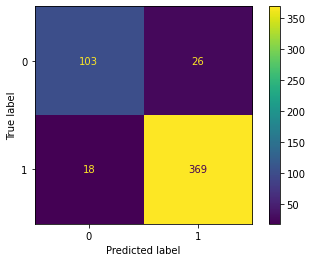

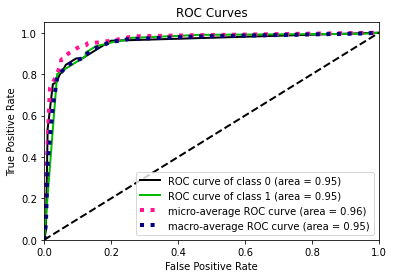

In [34]:
print_all(dt_grid,train_set,train_pred_dt,test_set,test_pred_dt)

## Bayesian classifier

In [35]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [36]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)
train_pred_gnb = gnb.predict(train_set)
#predict on the test set
test_pred_gnb = gnb.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.68      0.91      0.78       387
   low-level       0.97      0.85      0.91      1159

    accuracy                           0.87      1546
   macro avg       0.82      0.88      0.84      1546
weighted avg       0.89      0.87      0.87      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.69      0.93      0.79       129
   low-level       0.97      0.86      0.91       387

    accuracy                           0.88       516
   macro avg       0.83      0.89      0.85       516
weighted avg       0.90      0.88      0.88       516



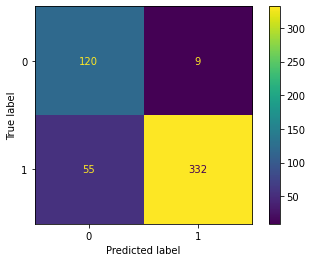

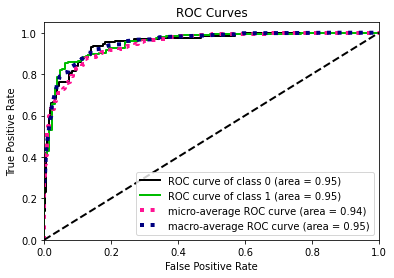

In [37]:
print_all(gnb,train_set,train_pred_gnb,test_set,test_pred_gnb)

## Neural Network

In [38]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [39]:
def create_model(n_neurons1, activation1, n_neurons2, activation2, optimizer, activation_out, loss): 
    # create model
    model = Sequential()
    model.add(Dense(n_neurons1, kernel_initializer='uniform', input_dim=19, activation=activation1)) 
    model.add(Dense(1,  kernel_initializer='uniform', activation=activation_out))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

In [40]:
grid_param = {
    "n_neurons1":[20],
    "activation1":["relu"],
    "n_neurons2":[20],
    "activation2":["softmax"],
    "optimizer": ['adam'],
#     "activation_out":["softmax","relu","sigmoid"],
#    "dropout_rate" : [0.2],
    "activation_out":["linear"],
    "loss":["mean_squared_error"]
}

nn = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32)
nn_grid = GridSearchCV(nn, param_grid=grid_param, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))


<ipython-input-40-4987c134f2e2>:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  nn = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32)


In [41]:
start = time.time()
best_model = nn_grid.fit(train_set, train_label)
print(nn_grid.best_params_)
train_pred_nn = nn_grid.predict(train_set)
test_pred_nn = nn_grid.predict(test_set)
print('Time taken for fit: {} sec\n'.format(time.time() - start))

Epoch 1/150
49/49 [==============================] - 0s 1ms/step - loss: 10.3672 - accuracy: 0.5873
Epoch 2/150
49/49 [==============================] - 0s 1ms/step - loss: 0.2265 - accuracy: 0.6850
Epoch 3/150
49/49 [==============================] - 0s 1ms/step - loss: 0.1698 - accuracy: 0.7141
Epoch 4/150
49/49 [==============================] - 0s 1ms/step - loss: 0.1512 - accuracy: 0.7536
Epoch 5/150
49/49 [==============================] - 0s 1ms/step - loss: 0.1385 - accuracy: 0.7762
Epoch 6/150
49/49 [==============================] - 0s 980us/step - loss: 0.1305 - accuracy: 0.7982
Epoch 7/150
49/49 [==============================] - 0s 1ms/step - loss: 0.1221 - accuracy: 0.8234
Epoch 8/150
49/49 [==============================] - 0s 1ms/step - loss: 0.1164 - accuracy: 0.8299
Epoch 9/150
49/49 [==============================] - 0s 1ms/step - loss: 0.1112 - accuracy: 0.8441
Epoch 10/150
49/49 [==============================] - 0s 1ms/step - loss: 0.1078 - accuracy: 0.8532
Epoch 

49/49 [==============================] - 0s 1ms/step - loss: 0.0873 - accuracy: 0.9030
Epoch 83/150
49/49 [==============================] - 0s 942us/step - loss: 0.0872 - accuracy: 0.9075
Epoch 84/150
49/49 [==============================] - 0s 907us/step - loss: 0.0726 - accuracy: 0.9114
Epoch 85/150
49/49 [==============================] - 0s 890us/step - loss: 0.0743 - accuracy: 0.9140
Epoch 86/150
49/49 [==============================] - 0s 891us/step - loss: 0.0742 - accuracy: 0.9133
Epoch 87/150
49/49 [==============================] - 0s 932us/step - loss: 0.0748 - accuracy: 0.9120
Epoch 88/150
49/49 [==============================] - 0s 972us/step - loss: 0.0803 - accuracy: 0.9069
Epoch 89/150
49/49 [==============================] - 0s 970us/step - loss: 0.0793 - accuracy: 0.9062
Epoch 90/150
49/49 [==============================] - 0s 986us/step - loss: 0.0861 - accuracy: 0.9036
Epoch 91/150
49/49 [==============================] - 0s 943us/step - loss: 0.0803 - accuracy: 0.

### Evaluation

In [42]:
test=best_model.best_estimator_
history=test.fit(train_set, train_label,
                    epochs=120,
                    batch_size=500,
                    validation_split=0.4)

Epoch 1/120
2/2 [==============================] - 1s 500ms/step - loss: 0.9788 - accuracy: 0.6688 - val_loss: 0.6292 - val_accuracy: 0.7205
Epoch 2/120
2/2 [==============================] - 0s 161ms/step - loss: 0.5814 - accuracy: 0.6785 - val_loss: 0.4274 - val_accuracy: 0.6769
Epoch 3/120
2/2 [==============================] - 0s 22ms/step - loss: 0.4814 - accuracy: 0.6127 - val_loss: 0.3888 - val_accuracy: 0.6010
Epoch 4/120
2/2 [==============================] - 0s 26ms/step - loss: 0.3100 - accuracy: 0.6872 - val_loss: 0.2084 - val_accuracy: 0.7302
Epoch 5/120
2/2 [==============================] - 0s 23ms/step - loss: 0.2861 - accuracy: 0.7184 - val_loss: 0.2678 - val_accuracy: 0.7738
Epoch 6/120
2/2 [==============================] - 0s 25ms/step - loss: 0.2679 - accuracy: 0.7195 - val_loss: 0.1807 - val_accuracy: 0.7803
Epoch 7/120
2/2 [==============================] - 0s 25ms/step - loss: 0.1914 - accuracy: 0.7799 - val_loss: 0.2815 - val_accuracy: 0.7674
Epoch 8/120
2/2 [=

2/2 [==============================] - 0s 22ms/step - loss: 0.0947 - accuracy: 0.8792 - val_loss: 0.1008 - val_accuracy: 0.8643
Epoch 60/120
2/2 [==============================] - 0s 22ms/step - loss: 0.0935 - accuracy: 0.8824 - val_loss: 0.1010 - val_accuracy: 0.8627
Epoch 61/120
2/2 [==============================] - 0s 22ms/step - loss: 0.0930 - accuracy: 0.8824 - val_loss: 0.1006 - val_accuracy: 0.8627
Epoch 62/120
2/2 [==============================] - 0s 21ms/step - loss: 0.0931 - accuracy: 0.8824 - val_loss: 0.1000 - val_accuracy: 0.8627
Epoch 63/120
2/2 [==============================] - 0s 24ms/step - loss: 0.0935 - accuracy: 0.8803 - val_loss: 0.1005 - val_accuracy: 0.8578
Epoch 64/120
2/2 [==============================] - 0s 22ms/step - loss: 0.0918 - accuracy: 0.8813 - val_loss: 0.0996 - val_accuracy: 0.8691
Epoch 65/120
2/2 [==============================] - 0s 22ms/step - loss: 0.0924 - accuracy: 0.8846 - val_loss: 0.0990 - val_accuracy: 0.8675
Epoch 66/120
2/2 [========

2/2 [==============================] - 0s 24ms/step - loss: 0.0809 - accuracy: 0.9029 - val_loss: 0.0876 - val_accuracy: 0.8885
Epoch 118/120
2/2 [==============================] - 0s 25ms/step - loss: 0.0809 - accuracy: 0.9018 - val_loss: 0.0902 - val_accuracy: 0.8740
Epoch 119/120
2/2 [==============================] - 0s 22ms/step - loss: 0.0817 - accuracy: 0.9029 - val_loss: 0.0871 - val_accuracy: 0.8885
Epoch 120/120
2/2 [==============================] - 0s 22ms/step - loss: 0.0811 - accuracy: 0.8997 - val_loss: 0.0871 - val_accuracy: 0.8788


<ipython-input-43-6ee03a03cdca>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
<ipython-input-43-6ee03a03cdca>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')


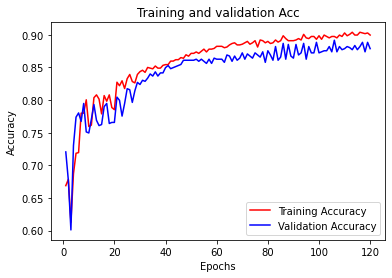

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<ipython-input-44-273a95ade490>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
<ipython-input-44-273a95ade490>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')


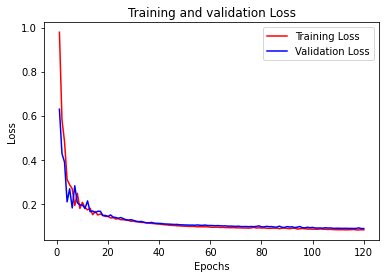

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TRAINING:
               precision    recall  f1-score   support

  high-level       0.85      0.81      0.83       387
   low-level       0.94      0.95      0.94      1159

    accuracy                           0.92      1546
   macro avg       0.89      0.88      0.89      1546
weighted avg       0.91      0.92      0.91      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.86      0.79      0.82       129
   low-level       0.93      0.96      0.94       387

    accuracy                           0.91       516
   macro avg       0.89      0.87      0.88       516
weighted avg       0.91      0.91      0.91       516



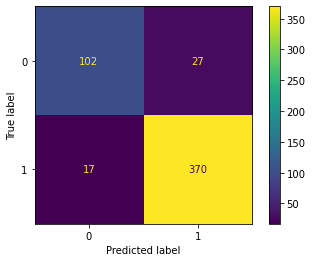

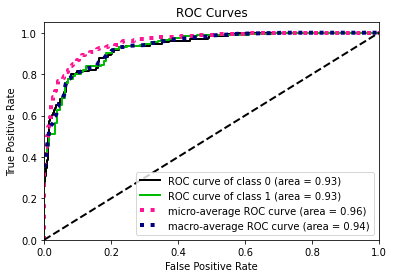

In [45]:
print_all(nn_grid,train_set,train_pred_nn,test_set,test_pred_nn)

## KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [47]:
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

k = math.sqrt(len(train_set))
k = round(k, 0)
k = int(k)
k = k - 10
k_range = []
for i in range(0,20):
    k_range.append(k)
    k = k + 1

In [48]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=8, scoring=make_scorer(f1_score))

In [49]:
knn_grid.fit(train_set_no_cat, train_label)

GridSearchCV(cv=8, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
                                         39, 40, 41, 42, 43, 44, 45, 46, 47,
                                         48],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score))

In [50]:
train_pred_knn = knn_grid.predict(train_set_no_cat)
test_pred_knn = knn_grid.predict(test_set_no_cat)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       387
   low-level       1.00      1.00      1.00      1159

    accuracy                           1.00      1546
   macro avg       1.00      1.00      1.00      1546
weighted avg       1.00      1.00      1.00      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.84      0.75      0.80       129
   low-level       0.92      0.95      0.94       387

    accuracy                           0.90       516
   macro avg       0.88      0.85      0.87       516
weighted avg       0.90      0.90      0.90       516



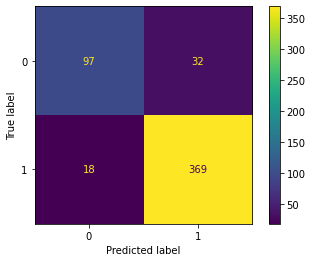

In [51]:
print_all(knn_grid,train_set_no_cat,train_pred_knn,test_set_no_cat,test_pred_knn,roc="None")

## Radius-Neighbors Classifier 

### Grid search

In [52]:
from sklearn.neighbors import RadiusNeighborsClassifier
from scipy.stats import uniform
#radius = np.arange(1.0, 100000.0, 0.1)
radius = uniform(1.0, 10000000.0)
radius_param_grid = {
    'radius': radius,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

### Training

In [53]:
radius_grid = RandomizedSearchCV(RadiusNeighborsClassifier(), radius_param_grid, n_jobs=-1, n_iter = 100, cv=8, scoring='accuracy')

radius_grid.fit(train_set_no_cat, train_label)

print('Accuracy: ' + str(radius_grid.best_score_))
print('Parameters: ' + str(radius_grid.best_params_))

Accuracy: 0.8357092302761605
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'radius': 3807538.6115241577, 'weights': 'distance'}


In [54]:
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set_no_cat, train_label)

In [55]:
train_pred_radius = radius.predict(train_set_no_cat)

In [56]:
test_pred_radius = radius.predict(test_set_no_cat)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       387
   low-level       1.00      1.00      1.00      1159

    accuracy                           1.00      1546
   macro avg       1.00      1.00      1.00      1546
weighted avg       1.00      1.00      1.00      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.84      0.52      0.64       129
   low-level       0.86      0.97      0.91       387

    accuracy                           0.85       516
   macro avg       0.85      0.74      0.78       516
weighted avg       0.85      0.85      0.84       516



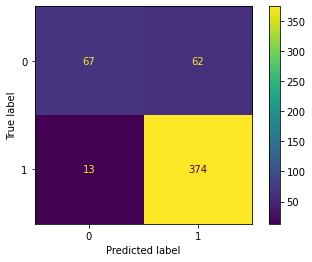

In [57]:
print_all(radius,train_set_no_cat,train_pred_radius,test_set_no_cat,test_pred_radius,roc="None")

## SVM

In [58]:
from sklearn.svm import SVC

In [59]:
svm_param_grid = {
    'C' : [0.5, 2.0],
    'kernel' : ['rbf', 'linear'] 
    }
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))

In [60]:
svm_grid.fit(train_set, train_label)

GridSearchCV(cv=8, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.5, 2.0], 'kernel': ['rbf', 'linear']},
             scoring=make_scorer(f1_score))

In [61]:
train_pred_svm = svm_grid.predict(train_set)
test_pred_svm = svm_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.88      0.87      0.88       387
   low-level       0.96      0.96      0.96      1159

    accuracy                           0.94      1546
   macro avg       0.92      0.91      0.92      1546
weighted avg       0.94      0.94      0.94      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.84      0.88      0.86       129
   low-level       0.96      0.95      0.95       387

    accuracy                           0.93       516
   macro avg       0.90      0.91      0.91       516
weighted avg       0.93      0.93      0.93       516



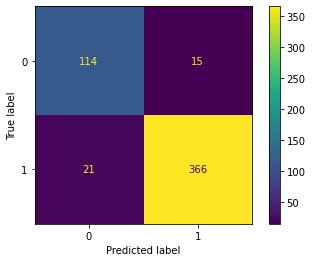

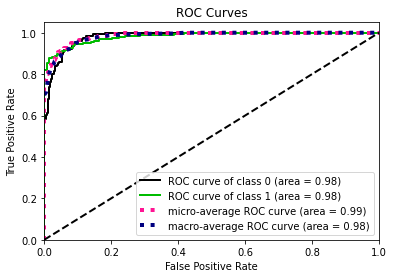

In [62]:
print_all(svm_grid,train_set,train_pred_svm,test_set,test_pred_svm)

## Rule Based Classifier

In [63]:
import wittgenstein as lw
param_grid = {
    "prune_size": [0.1, 0.2, 0.5, 0.6], 
    "k": [1, 3, 7, 10]
}
rb_grid = GridSearchCV(lw.RIPPER(), param_grid=param_grid, n_jobs=10)

In [64]:
rb_grid.fit(train_set, train_label)

GridSearchCV(estimator=<RIPPER(max_rules=None, random_state=None, k=2, prune_size=0.33, verbosity=0, max_rule_conds=None, dl_allowance=64, n_discretize_bins=10, max_total_conds=None)>,
             n_jobs=10,
             param_grid={'k': [1, 3, 7, 10],
                         'prune_size': [0.1, 0.2, 0.5, 0.6]})

In [65]:
rb = rb_grid.best_estimator_
rb.out_model()

[[hand_num=2] V
[ratio_2020-2021=<0.22 ^ bpFaced=121.0-194.0] V
[ratio_2020-2021=<0.22 ^ bpFaced=<121.0] V
[ratio_2020-2021=<0.22 ^ bpFaced=194.0-305.0] V
[minutes=61.86-66.12] V
[bpFaced=305.0-450.0 ^ gender_num=0] V
[minutes=60.51-61.86] V
[bpFaced=305.0-450.0 ^ serv_won_tot_seve=0.59-0.61] V
[num_matches_2016-2019=<14.0] V
[bpFaced=686.0-957.0 ^ ratio_2016-2019=0.43-0.47] V
[bpFaced=957.0-1316.0 ^ ratio_2020-2021=0.22-0.38] V
[bpFaced=305.0-450.0 ^ perc_v_df=7.35-7.83] V
[minutes=<60.51] V
[num_matches_2016-2019=85.0-118.0 ^ gender_num=1 ^ serv_won_tot_seve=0.59-0.61] V
[bpFaced=305.0-450.0] V
[ratio=0.4-0.44] V
[minutes=66.12-76.39 ^ birth=>2000.0] V
[gender_num=1 ^ num_matches_2016-2019=85.0-118.0] V
[minutes=66.12-76.39 ^ num_matches_2016-2019=56.0-85.0] V
[num_matches_2020-2021=1.0-4.0 ^ serv_won_tot_seve=0.59-0.61] V
[perc_v_df=6.97-7.35 ^ ratio_2016-2019=0.5-0.52] V
[num_matches_2016-2019=14.0-23.0] V
[num_matches_2016-2019=23.0-37.5] V
[ratio_2016-2019=0.47-0.5 ^ ratio_2020-2

In [66]:
train_pred_rb = rb_grid.predict(train_set)
test_pred_rb = rb_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.78      0.90      0.84       387
   low-level       0.97      0.92      0.94      1159

    accuracy                           0.91      1546
   macro avg       0.88      0.91      0.89      1546
weighted avg       0.92      0.91      0.92      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.69      0.88      0.77       129
   low-level       0.95      0.87      0.91       387

    accuracy                           0.87       516
   macro avg       0.82      0.87      0.84       516
weighted avg       0.89      0.87      0.87       516



base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [27, 83, 87, 114, 123, 143, 180, 203, 204, 216, 265, 277, 283, 289, 294, 325, 349, 351, 356, 360, 417, 430, 443, 456, 470, 474, 478, 479, 488, 504]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



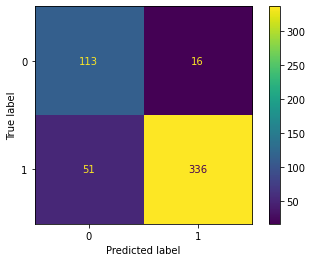

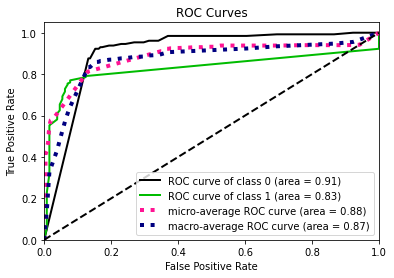

In [67]:
print_all(rb_grid,train_set,train_pred_rb,test_set,test_pred_rb)

## Random Forest Classifier

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.65, 1: 0.35}]}

rf_grid = RandomizedSearchCV(RandomForestClassifier(n_estimators=30), param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))


In [70]:
#run the grid search
rf_grid.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.65, 1: 0.35}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DCAE1EB550>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DCAE1EBEE0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DCAE612280>},
                   scoring=make_scorer(accuracy_sc

In [71]:
train_pred_rf = rf_grid.predict(train_set)
test_pred_rf = rf_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.89      0.91      0.90       387
   low-level       0.97      0.96      0.97      1159

    accuracy                           0.95      1546
   macro avg       0.93      0.93      0.93      1546
weighted avg       0.95      0.95      0.95      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.87      0.86      0.86       129
   low-level       0.95      0.96      0.95       387

    accuracy                           0.93       516
   macro avg       0.91      0.91      0.91       516
weighted avg       0.93      0.93      0.93       516



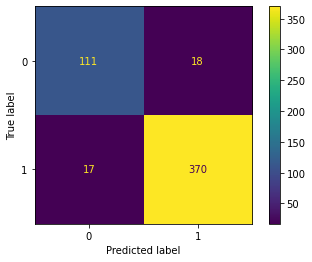

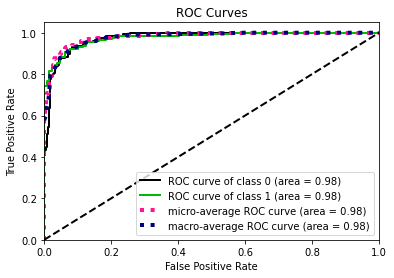

In [72]:
print_all(rf_grid,train_set,train_pred_rf,test_set,test_pred_rf)

## AdaBoosting

In [73]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(train_set, train_label)

AdaBoostClassifier()

In [74]:
test_pred_abc = abc.predict(test_set)
train_pred_abc= abc.predict(train_set)

TRAINING:
               precision    recall  f1-score   support

  high-level       0.92      0.92      0.92       387
   low-level       0.97      0.97      0.97      1159

    accuracy                           0.96      1546
   macro avg       0.95      0.95      0.95      1546
weighted avg       0.96      0.96      0.96      1546

TEST:
               precision    recall  f1-score   support

  high-level       0.85      0.89      0.87       129
   low-level       0.96      0.95      0.96       387

    accuracy                           0.93       516
   macro avg       0.91      0.92      0.91       516
weighted avg       0.94      0.93      0.93       516



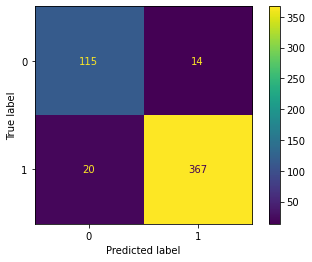

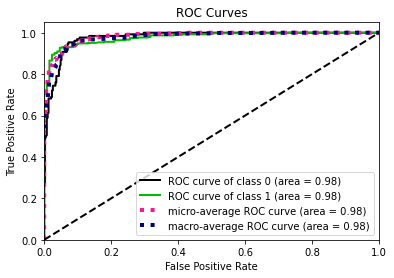

In [75]:
print_all(abc,train_set,train_pred_abc,test_set,test_pred_abc)

## Global models evaluation

Compare results on test set of each model obtained with grid search

In [76]:
df_blind_test = pd.DataFrame()
df_blind_test['DecisionTree'] = pd.Series(dt_grid.predict(blindtest))
df_blind_test['Bayesian'] = pd.Series(gnb.predict(blindtest))
#df_blind_test['NeuralNetwork'] = pd.Series(nn_grid.predict(blindtest))
#df_blind_test['KNN'] = pd.Series(knn_grid.predict(blindtest))
#df_blind_test['Radius-KNN'] = pd.Series(radius_grid.predict(blindtest))
df_blind_test['SVM'] = pd.Series(svm_grid.predict(blindtest))
df_blind_test['RuleBased'] = pd.Series(rb_grid.predict(blindtest))
df_blind_test['RandomForest'] = pd.Series(rf_grid.predict(blindtest))
df_blind_test['AdaBoosting'] = pd.Series(abc.predict(blindtest))
df_blind_test

,DecisionTree,Bayesian,SVM,RuleBased,RandomForest,AdaBoosting
0,1,1,1,True,1,1
1,1,1,1,True,1,1
2,1,1,1,True,1,1
3,1,1,1,True,1,1
4,1,1,1,True,1,1
5,1,1,1,True,1,1
6,1,1,1,True,1,1
7,1,1,1,True,1,1
8,1,1,1,True,1,1
9,1,1,1,True,1,1


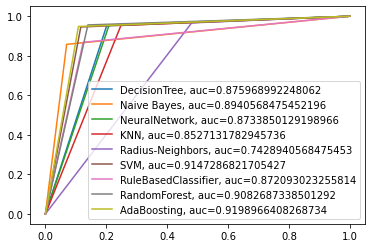

In [77]:
## aggiungi gli altri modelli sotto 

#decision tree 
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

#bayesian classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

#neural network
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_nn)
auc = metrics.roc_auc_score(test_label, test_pred_nn)
plt.plot(fpr,tpr,label="NeuralNetwork, auc="+str(auc))

#KNN
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_knn)
auc = metrics.roc_auc_score(test_label, test_pred_knn)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

#Radius-Neighbors
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_radius)
auc = metrics.roc_auc_score(test_label, test_pred_radius)
plt.plot(fpr,tpr,label="Radius-Neighbors, auc="+str(auc))

#SVM
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_svm)
auc = metrics.roc_auc_score(test_label, test_pred_svm)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

#Rule Based Classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rb)
auc = metrics.roc_auc_score(test_label, test_pred_rb)
plt.plot(fpr,tpr,label="RuleBasedClassifier, auc="+str(auc))

#RandomForest
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

#AdaBoosting
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_abc)
auc = metrics.roc_auc_score(test_label, test_pred_abc)
plt.plot(fpr,tpr,label="AdaBoosting, auc="+str(auc))

plt.legend(loc=0)